# Instalar Julia

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.9.1" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools LinearAlgebra Statistics Flux MLDatasets BetaML Printf BSON"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.9.1 on the current Colab Runtime...
2023-06-19 23:30:12 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.9/julia-1.9.1-linux-x86_64.tar.gz [146318973/146318973] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...
Installing Julia package LinearAlgebra...
Installing Julia package Statistics...
Installing Julia package Flux...


# Codigo de treinamento

In [ ]:
using LinearAlgebra, Statistics, Flux, MLDatasets, CUDA
using BetaML: ConfusionMatrix, fit!, info
using Printf, BSON

In [ ]:
# Treino
class_names = MLDatasets.CIFAR10().metadata["class_names"]
x_treino, y_treino = MLDatasets.CIFAR10(Float32, split=:train)[:] |> gpu

média_x_treino = mean(x_treino);
desvio_x_treino = std(x_treino);
x_treino = (x_treino .- média_x_treino) ./ desvio_x_treino;
y_treino = Flux.onehotbatch(y_treino, 0:9)
dados_treino = Flux.Data.DataLoader((x_treino, y_treino), batchsize=128)

391-element DataLoader(::Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, OneHotArrays.OneHotMatrix{UInt32, CuArray{UInt32, 1, CUDA.Mem.DeviceBuffer}}}, batchsize=128)
  with first element:
  (32×32×3×128 CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, 10×128 OneHotMatrix(::CuArray{UInt32, 1, CUDA.Mem.DeviceBuffer}) with eltype Bool,)

In [ ]:
# Teste
x_teste, y_teste = MLDatasets.CIFAR10(Float32, split=:test)[:] |> gpu

média_x_teste = mean(x_teste);
desvio_x_teste = std(x_teste);
x_teste = (x_teste .- média_x_teste) ./ desvio_x_teste;

y_teste = Flux.onehotbatch(y_teste, 0:9)


10×10000 OneHotMatrix(::CuArray{UInt32, 1, CUDA.Mem.DeviceBuffer}) with eltype Bool:
 ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  …  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  1  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  …  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  1  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1
 ⋅  1  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅

In [ ]:
modelo = Chain(
    Conv((3, 3), 3 => 64, relu, pad=(1, 1), stride=(1, 1)),
    BatchNorm(64),
    Conv((3, 3), 64 => 64, relu, pad=(1, 1), stride=(1, 1)),
    BatchNorm(64),
    MaxPool((2,2)),
    Conv((3, 3), 64 => 128, relu, pad=(1, 1), stride=(1, 1)),
    BatchNorm(128),
    Conv((3, 3), 128 => 128, relu, pad=(1, 1), stride=(1, 1)),
    BatchNorm(128),
    MaxPool((2,2)),
    Conv((3, 3), 128 => 256, relu, pad=(1, 1), stride=(1, 1)),
    BatchNorm(256),
    Conv((3, 3), 256 => 256, relu, pad=(1, 1), stride=(1, 1)),
    BatchNorm(256),
    Conv((3, 3), 256 => 256, relu, pad=(1, 1), stride=(1, 1)),
    BatchNorm(256),
    Conv((3, 3), 256 => 256, relu, pad=(1, 1), stride=(1, 1)),
    MaxPool((2,2)),
    Conv((3, 3), 256 => 512, relu, pad=(1, 1), stride=(1, 1)),
    BatchNorm(512),
    Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
    BatchNorm(512),
    Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
    BatchNorm(512),
    Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
    MaxPool((2,2)),
    Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
    BatchNorm(512),
    Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
    BatchNorm(512),
    Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
    BatchNorm(512),
    Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
    MaxPool((2,2)),
    x -> reshape(x, :, size(x, 4)),
    Dense(512, 4096, relu),
    Dropout(0.5),
    Dense(4096, 4096, relu),
    Dropout(0.5),
    Dense(4096, 10),
    softmax) |> gpu

Chain(
  Conv((3, 3), 3 => 64, relu, pad=1),   # 1_792 parameters
  BatchNorm(64),                        # 128 parameters, plus 128
  Conv((3, 3), 64 => 64, relu, pad=1),  # 36_928 parameters
  BatchNorm(64),                        # 128 parameters, plus 128
  MaxPool((2, 2)),
  Conv((3, 3), 64 => 128, relu, pad=1),  # 73_856 parameters
  BatchNorm(128),                       # 256 parameters, plus 256
  Conv((3, 3), 128 => 128, relu, pad=1),  # 147_584 parameters
  BatchNorm(128),                       # 256 parameters, plus 256
  MaxPool((2, 2)),
  Conv((3, 3), 128 => 256, relu, pad=1),  # 295_168 parameters
  BatchNorm(256),                       # 512 parameters, plus 512
  Conv((3, 3), 256 => 256, relu, pad=1),  # 590_080 parameters
  BatchNorm(256),                       # 512 parameters, plus 512
  Conv((3, 3), 256 => 256, relu, pad=1),  # 590_080 parameters
  BatchNorm(256),                       # 512 parameters, plus 512
  Conv((3, 3), 256 => 256, relu, pad=1),  # 590_080 pa

In [ ]:
acuracia(ŷ, y) = (mean(Flux.onecold(ŷ) .== Flux.onecold(y)))
perda(x, y) = Flux.crossentropy(modelo(x), y)

opt = Flux.ADAM(0.001)
ps = Flux.params(modelo)

num_épocas = 25
melhor_acu = 0
última_melhoria = 0

for época in 1:num_épocas
   println("Época ", época)
   Flux.train!(perda, ps, dados_treino, opt)

   ŷteste = modelo(x_teste)
   acu = acuracia(ŷteste, y_teste)

   @info(@sprintf("[%d]: Acurácia nos testes: %.4f", época, acu))

   if acu >= melhor_acu
      global melhor_acu = acu
      global última_melhoria = época
      let model = cpu(modelo)
        BSON.@save "./trained_model_cifar10.bson" model
      end
   end
   # Se a acurácia for muito boa, termine o treino
   if acu >= 0.999
      @info(" -> Término prematuro: alcançamos uma acurácia de 99.9%")
      break
   end

   # Se não houve melhoria em 5 épocas, reduza a taxa de aprendizagem:
   if época - última_melhoria >= 5 && opt.eta > 1e-6
      opt.eta /= 10.0
      @warn(" -> Sem melhoria por enquanto, reduzindo a taxa de aprendizagem para $(opt.eta)!")

      # Após reduzir a taxa de aprendizagem, dê a ela umas poucas épocas para melhorar
      última_melhoria = época
   end

   if época - última_melhoria >= 10
      @warn(" -> Consideramos que houve convergência.")
      break
   end
end


Época 1


[ Info: [1]: Acurácia nos testes: 0.4503


Época 2


[ Info: [2]: Acurácia nos testes: 0.5869


Época 3


[ Info: [3]: Acurácia nos testes: 0.6537


Época 4


[ Info: [4]: Acurácia nos testes: 0.6957


Época 5


[ Info: [5]: Acurácia nos testes: 0.7543


Época 6


[ Info: [6]: Acurácia nos testes: 0.7611


Época 7
Época 8


[ Info: [7]: Acurácia nos testes: 0.5549


Época 9


[ Info: [8]: Acurácia nos testes: 0.7245
[ Info: [9]: Acurácia nos testes: 0.7688


Época 10


[ Info: [10]: Acurácia nos testes: 0.7779


Época 11


[ Info: [11]: Acurácia nos testes: 0.8093


Época 12


[ Info: [12]: Acurácia nos testes: 0.8126


Época 13


[ Info: [13]: Acurácia nos testes: 0.8167


Época 14
Época 15


[ Info: [14]: Acurácia nos testes: 0.8044
[ Info: [15]: Acurácia nos testes: 0.8172


Época 16


[ Info: [16]: Acurácia nos testes: 0.8225


Época 17
Época 18


[ Info: [17]: Acurácia nos testes: 0.8143
[ Info: [18]: Acurácia nos testes: 0.8307


Época 19
Época 20


[ Info: [19]: Acurácia nos testes: 0.8224


Época 21


[ Info: [20]: Acurácia nos testes: 0.8234


Época 22


[ Info: [21]: Acurácia nos testes: 0.8303
[ Info: [22]: Acurácia nos testes: 0.8403


Época 23
Época 24


[ Info: [23]: Acurácia nos testes: 0.8379


Época 25


[ Info: [24]: Acurácia nos testes: 0.8171
[ Info: [25]: Acurácia nos testes: 0.8335


Salvando modelo

In [ ]:
let model = cpu(modelo)
   BSON.@save "./trained_model_cifar10.bson" model
end

# Código de teste

Inserção bibliotecas

In [29]:
using LinearAlgebra, Statistics, Flux, MLDatasets, CUDA
using BetaML: ConfusionMatrix, fit!, info
using Printf, BSON


Carregando o modelo

In [30]:
BSON.@load "trained_model_cifar10_84.bson" model
model = gpu(model)

Chain(
  Conv((3, 3), 3 => 64, relu, pad=1),   # 1_792 parameters
  BatchNorm(64),                        # 128 parameters, plus 128
  Conv((3, 3), 64 => 64, relu, pad=1),  # 36_928 parameters
  BatchNorm(64),                        # 128 parameters, plus 128
  MaxPool((2, 2)),
  Conv((3, 3), 64 => 128, relu, pad=1),  # 73_856 parameters
  BatchNorm(128),                       # 256 parameters, plus 256
  Conv((3, 3), 128 => 128, relu, pad=1),  # 147_584 parameters
  BatchNorm(128),                       # 256 parameters, plus 256
  MaxPool((2, 2)),
  Conv((3, 3), 128 => 256, relu, pad=1),  # 295_168 parameters
  BatchNorm(256),                       # 512 parameters, plus 512
  Conv((3, 3), 256 => 256, relu, pad=1),  # 590_080 parameters
  BatchNorm(256),                       # 512 parameters, plus 512
  Conv((3, 3), 256 => 256, relu, pad=1),  # 590_080 parameters
  BatchNorm(256),                       # 512 parameters, plus 512
  Conv((3, 3), 256 => 256, relu, pad=1),  # 590_080 pa

Importação dos dados de teste

In [31]:
x_teste, y_teste = MLDatasets.CIFAR10(Float32, split=:test)[:] |> gpu

média_x_teste = mean(x_teste);
desvio_x_teste = std(x_teste);
x_teste = (x_teste .- média_x_teste) ./ desvio_x_teste;

y_teste = Flux.onehotbatch(y_teste, 0:9)

10×10000 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  …  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  1  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  …  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  1  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1
 ⋅  1  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅

Gerando resultados do modelo a partir do conjunto de teste

In [4]:
ŷteste = model(x_teste)

Matriz de confusão


In [ ]:
cm = ConfusionMatrix()
fit!(cm, Flux.onecold(y_teste) .- 1, Flux.onecold(ŷteste) .- 1)
print(cm)

info(cm)

A ConfusionMatrix BetaMLModel (fitted)

-----------------------------------------------------------------

*** CONFUSION MATRIX ***

Scores actual (rows) vs predicted (columns):

11×11 Matrix{Any}:
 "Labels"     "3"     "8"     "0"     "6"     "1"     "9"     "5"     "7"     "4"     "2"
 "3"       716      19      14      54       3       7      69      14      51      53
 "8"        10     925      35       2       6      18       1       0       0       3
 "0"         8      62     872       1       1      24       0       2      13      17
 "6"        36      15       7     874       1       0       2       4      15      46
 "1"         2      30       6       2     905      53       1       1       0       0
 "9"         6      28      19       1      32     910       1       2       0       1
 "5"       165       9       3      13       0       1     714      21      44      30
 "7"        29       6      24       2       0       3      27     859      42       8
 "4"        27  

Dict{String, Any} with 21 entries:
  "mean_precision"    => (0.842722, 0.842722)
  "fitted_records"    => 10000
  "specificity"       => [0.963778, 0.978778, 0.980333, 0.987, 0.995222, 0.9877…
  "precision"         => [0.68714, 0.828853, 0.831268, 0.881937, 0.954641, 0.89…
  "misclassification" => 0.1597
  "mean_recall"       => (0.8403, 0.8403)
  "n_categories"      => 10
  "normalised_scores" => [0.716 0.019 … 0.051 0.053; 0.01 0.925 … 0.0 0.003; … …
  "tn"                => [8674, 8809, 8823, 8883, 8957, 8890, 8879, 8926, 8774,…
  "mean_f1score"      => (0.840186, 0.840186)
  "actual_count"      => [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,…
  "accuracy"          => 0.8403
  "recall"            => [0.716, 0.925, 0.872, 0.874, 0.905, 0.91, 0.714, 0.859…
  "f1score"           => [0.701273, 0.874291, 0.851147, 0.877951, 0.929158, 0.9…
  "mean_specificity"  => (0.982256, 0.982256)
  "predicted_count"   => [1042, 1116, 1049, 991, 948, 1020, 835, 933, 1090, 976]
  "scores"    

Visualização de uma das imagens

truck

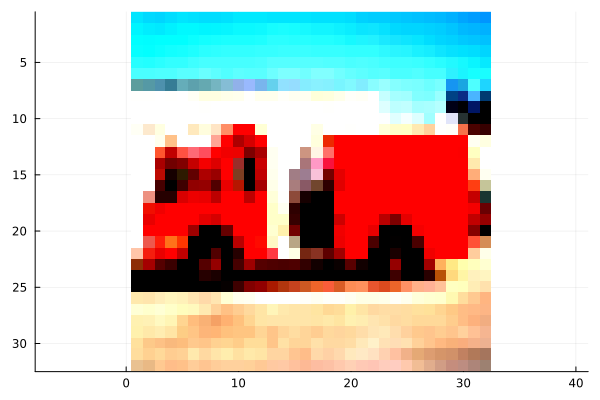

In [28]:
class_names = MLDatasets.CIFAR10().metadata["class_names"]
image(x) = colorview(RGB, permutedims(x, (3, 2, 1)))

print(class_names[Flux.onecold(y_teste[:, 365])]) 
plot(image(x_teste[:, :, :, 365]))